# Full Company Market Analysis 

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
plt.style.use("ggplot")

# Word clouds, just in case
from wordcloud import WordCloud

# sklearn (if you’ll add clustering/classification to your market analysis)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [24]:
# Loas the data
textblob_df = pd.read_csv("/Users/devishi/Uni_CW/FinalYearProject/Code/DA_FYP/cleaned_glassdoor_reviews_with_textblob.csv")

In [25]:
# check missing values
textblob_df.isna().sum()

Company                 0
Date Posted             0
Job Title               0
Location                0
Overall Rating          0
Work/Life Balance       0
Company Culture         0
Diversity Inclusion     0
Career Opportunity      0
Company Benefits        0
Management              0
Post Title              0
Pros                    0
Cons                    0
pros_length             0
cons_length             0
Review_Combined         0
Review_Clean           32
TextBlob_Score         32
dtype: int64

In [26]:
# drop missing values from Review_Clean and TextBlob_Score
textblob_df.dropna(subset=['Review_Clean'], inplace=True)
textblob_df.dropna(subset=['TextBlob_Score'], inplace=True)


In [27]:
# Check if the missing values are dropped
textblob_df.isna().sum()

Company                0
Date Posted            0
Job Title              0
Location               0
Overall Rating         0
Work/Life Balance      0
Company Culture        0
Diversity Inclusion    0
Career Opportunity     0
Company Benefits       0
Management             0
Post Title             0
Pros                   0
Cons                   0
pros_length            0
cons_length            0
Review_Combined        0
Review_Clean           0
TextBlob_Score         0
dtype: int64

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/2510182743.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average_Sentiment', y='Company', data=company_sentiment, palette='viridis')


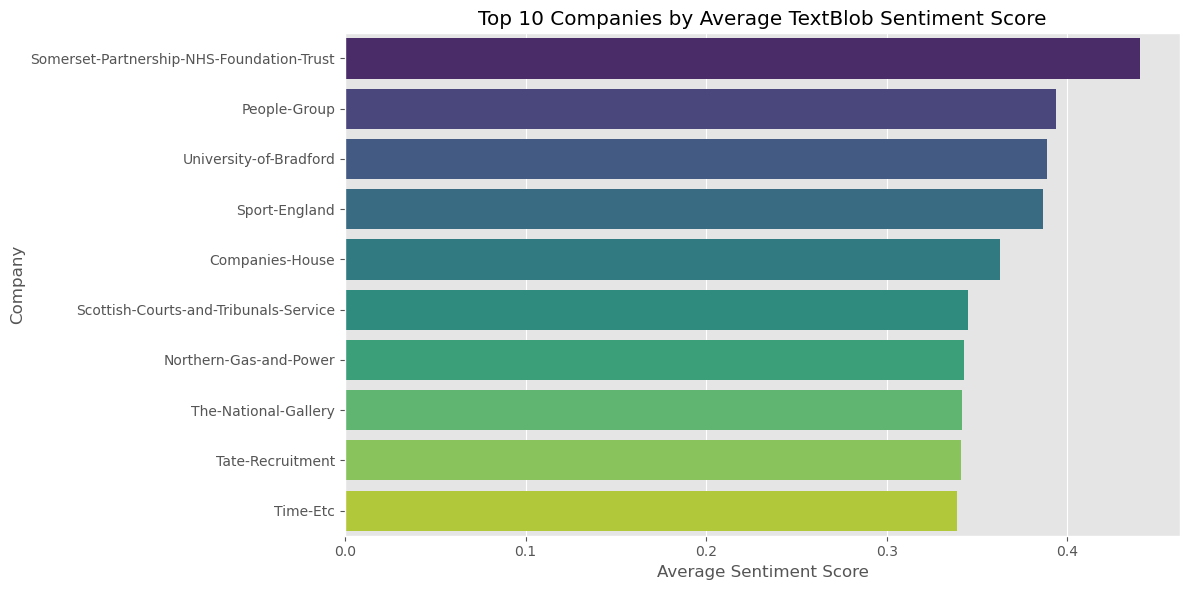

In [ ]:

# Group by company and calculate the average sentiment score
company_sentiment = (
    textblob_df.groupby('Company')
    .agg(Average_Sentiment=('TextBlob_Score', 'mean'),
         Review_Count=('TextBlob_Score', 'count'))
    .sort_values(by='Average_Sentiment', ascending=False)
    .head(10)
)

# Reset index for plotting
company_sentiment = company_sentiment.reset_index()

# Plot the top 20 companies by average sentiment score
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Average_Sentiment', y='Company', data=company_sentiment, palette='viridis')
plt.title("Top 10 Companies by Average TextBlob Sentiment Score")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Company")
plt.tight_layout()
plt.show()



In [ ]:
# table for each department showing top 5 companies based on combined rating + sentiment score

from IPython.display import display

# List of department columns
department_cols = [
    'Work/Life Balance',
    'Company Culture',
    'Diversity Inclusion',
    'Career Opportunity',
    'Company Benefits',
    'Management'
]

# Loop through each department and generate styled table
for department in department_cols:
    # Drop rows with missing values in this department
    temp_df = textblob_df[['Company', department, 'TextBlob_Score']].dropna()

    # Compute averages per company
    avg_ratings = temp_df.groupby('Company')[department].mean()
    avg_sentiment = temp_df.groupby('Company')['TextBlob_Score'].mean()

    # Normalize both
    norm_ratings = (avg_ratings - avg_ratings.min()) / (avg_ratings.max() - avg_ratings.min())
    norm_sentiment = (avg_sentiment - avg_sentiment.min()) / (avg_sentiment.max() - avg_sentiment.min())

    # Combine scores
    combined_score = (norm_ratings + norm_sentiment) / 2
    top10_companies = combined_score.sort_values(ascending=False).head(10).index

    
    result_table = pd.DataFrame({
        'Company': top10_companies,
        'Avg Department Rating': avg_ratings[top10_companies].round(2).values,
        'Avg Sentiment Score': avg_sentiment[top10_companies].round(3).values,
        'Combined Score': combined_score[top10_companies].round(3).values
    })


    result_table.reset_index(drop=True, inplace=True)


    print(f"\nTop 10 Companies for '{department}' :\n")
    display(result_table.style.set_table_attributes("style='display:inline'").background_gradient(cmap="Blues").format({
        'Avg Department Rating': "{:.2f}",
        'Avg Sentiment Score': "{:.3f}",
        'Combined Score': "{:.3f}"
    }))



Top 10 Companies for 'Work/Life Balance' :



,Company,Avg Department Rating,Avg Sentiment Score,Combined Score
0,Somerset-Partnership-NHS-Foundation-Trust,4.25,0.440,0.912
1,Northern-Gas-and-Power,4.69,0.343,0.910
2,Sport-England,4.42,0.387,0.896
3,Time-Etc,4.62,0.339,0.893
4,Companies-House,4.39,0.363,0.868
5,Abcam,4.50,0.289,0.821
6,Immediate-Media-Company,4.31,0.325,0.817
7,Kingsley-Healthcare,4.25,0.339,0.817
8,Michelmores,4.40,0.301,0.814
9,Covea-Insurance,4.27,0.306,0.792



Top 10 Companies for 'Company Culture' :



,Company,Avg Department Rating,Avg Sentiment Score,Combined Score
0,Somerset-Partnership-NHS-Foundation-Trust,4.25,0.440,0.916
1,Time-Etc,4.69,0.339,0.906
2,Northern-Gas-and-Power,4.64,0.343,0.901
3,Kingsley-Healthcare,4.43,0.339,0.857
4,CarShop-UK,4.49,0.321,0.851
5,Immediate-Media-Company,4.44,0.325,0.846
6,Sport-England,4.12,0.387,0.842
7,Taylor-Wimpey,4.40,0.313,0.827
8,Michelmores,4.44,0.301,0.824
9,Abcam,4.50,0.289,0.823



Top 10 Companies for 'Diversity Inclusion' :



,Company,Avg Department Rating,Avg Sentiment Score,Combined Score
0,Kingsley-Healthcare,4.41,0.339,0.906
1,Somerset-Partnership-NHS-Foundation-Trust,4.00,0.440,0.855
2,University-of-Bradford,4.10,0.388,0.843
3,Time-Etc,4.17,0.339,0.820
4,Sport-England,4.04,0.387,0.820
5,People-Group,4.02,0.394,0.817
6,UHMBT,4.29,0.270,0.801
7,Companies-House,4.04,0.363,0.798
8,Orbit-Group,4.13,0.317,0.787
9,Northern-Gas-and-Power,4.06,0.343,0.786



Top 10 Companies for 'Career Opportunity' :



,Company,Avg Department Rating,Avg Sentiment Score,Combined Score
0,Northern-Gas-and-Power,4.63,0.343,0.903
1,Time-Etc,4.62,0.339,0.897
2,Kingsley-Healthcare,4.39,0.339,0.853
3,CarShop-UK,4.46,0.321,0.850
4,Somerset-Partnership-NHS-Foundation-Trust,3.62,0.440,0.805
5,People-Group,3.79,0.394,0.792
6,Anglian-Water,4.13,0.322,0.791
7,Michelmores,4.22,0.301,0.788
8,Sport-England,3.79,0.387,0.786
9,Western-Health-and-Social-Care-Trust,4.08,0.326,0.785



Top 10 Companies for 'Company Benefits' :



,Company,Avg Department Rating,Avg Sentiment Score,Combined Score
0,Somerset-Partnership-NHS-Foundation-Trust,4.12,0.440,0.923
1,Northern-Gas-and-Power,4.69,0.343,0.910
2,Time-Etc,4.31,0.339,0.854
3,CarShop-UK,4.41,0.321,0.851
4,Kingsley-Healthcare,4.25,0.339,0.845
5,Anglian-Water,4.32,0.322,0.841
6,Sport-England,3.88,0.387,0.840
7,Companies-House,3.91,0.363,0.823
8,Facebook,4.38,0.292,0.820
9,LinkedIn,4.15,0.321,0.817



Top 10 Companies for 'Management' :



,Company,Avg Department Rating,Avg Sentiment Score,Combined Score
0,Northern-Gas-and-Power,4.62,0.343,0.910
1,Time-Etc,4.62,0.339,0.906
2,Somerset-Partnership-NHS-Foundation-Trust,4.00,0.440,0.877
3,CarShop-UK,4.47,0.321,0.860
4,Kingsley-Healthcare,4.36,0.339,0.854
5,Sport-England,3.83,0.387,0.795
6,Gateley,4.25,0.289,0.788
7,Taylor-Wimpey,4.13,0.313,0.786
8,Anglian-Water,4.09,0.322,0.785
9,Michelmores,4.14,0.301,0.777


### Heatmap comparing top 10 companies across all departments

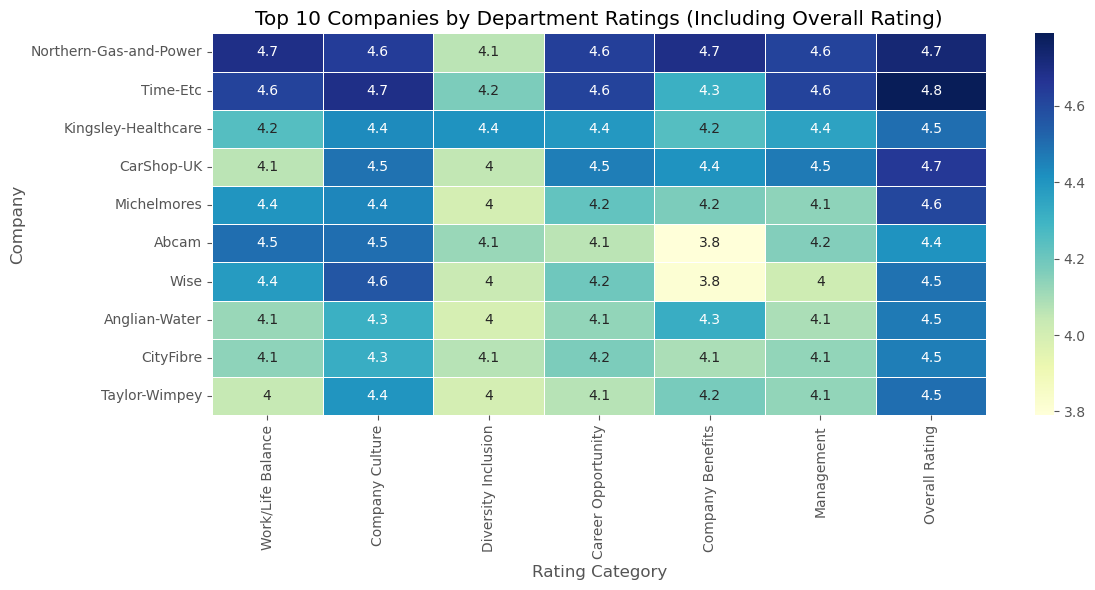

In [ ]:
# Drop rows with NA across any department
dept_df = textblob_df[['Company', 'Overall Rating'] + department_cols].dropna()

# Group by company to get average of all departments and overall rating
company_dept_scores = dept_df.groupby('Company')[department_cols + ['Overall Rating']].mean()

company_dept_scores['Department Avg'] = company_dept_scores[department_cols].mean(axis=1)

# Get top 10 companies based on department average
top10_companies = company_dept_scores.sort_values(by='Department Avg', ascending=False).head(10)

heatmap_data = top10_companies.drop(columns='Department Avg').round(2)

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Top 10 Companies by Department Ratings (Including Overall Rating)")
plt.xlabel("Rating Category")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

What this helps you show:
Which companies are consistently strong across all departments
Which are strong in one area but weaker in others
Whether a high overall rating aligns with department ratings

### Dot matrix 

In [ ]:
# Dot Matrix for Top 10 Companies (from heatmap step)
# marks each department where a company appeared in the top 5 by combined score

dot_matrix = pd.DataFrame(0, index=top10_companies, columns=department_cols)

# For each department, determine the top 10 companies (based on Step 1 logic)
for department in department_cols:
    temp_df = textblob_df[['Company', department, 'TextBlob_Score']].dropna()
    
    avg_ratings = temp_df.groupby('Company')[department].mean()
    avg_sentiment = temp_df.groupby('Company')['TextBlob_Score'].mean()
    
    norm_ratings = (avg_ratings - avg_ratings.min()) / (avg_ratings.max() - avg_ratings.min())
    norm_sentiment = (avg_sentiment - avg_sentiment.min()) / (avg_sentiment.max() - avg_sentiment.min())
    
    combined_score = (norm_ratings + norm_sentiment) / 2
    top10 = combined_score.sort_values(ascending=False).head(10).index

    for company in top10:
        if company in dot_matrix.index:
            dot_matrix.loc[company, department] = 1

# Plot the dot matrix
plt.figure(figsize=(10, 6))
sns.heatmap(dot_matrix, cmap="Blues", linewidths=0.5, linecolor='lightgray', cbar=False, annot=True, fmt="d")
plt.title("Dot Matrix: Top 10 Companies' Appearances in Department Ratings")
plt.xlabel("Department")
plt.ylabel("Company")
plt.tight_layout()
plt.show()


ValueError: Index data must be 1-dimensional

### Sentiment vs Overall Rating

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/1939298595.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sentiment_rating_df, x='Overall Rating', y='TextBlob_Score', palette='Set2')


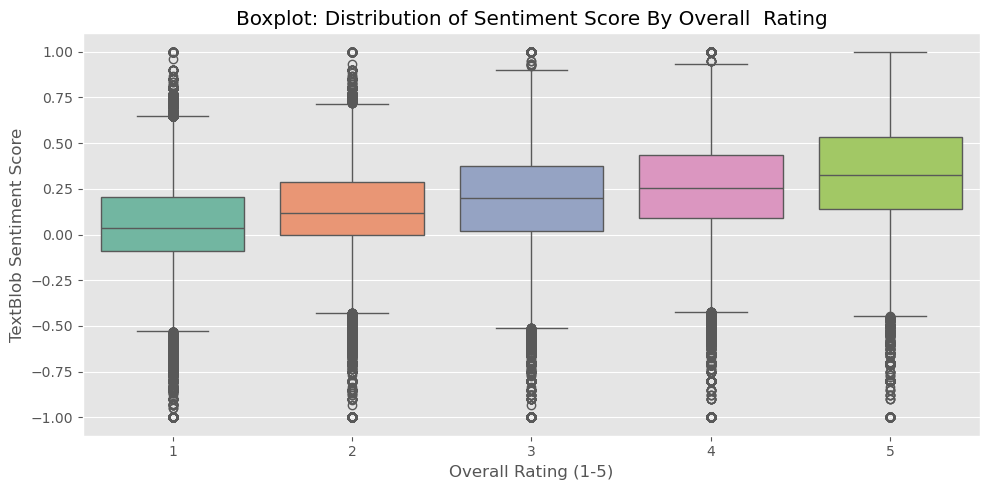

In [ ]:
# Analyze Sentiment vs Overall Rating using scatter and boxplot

sentiment_rating_df = textblob_df[['TextBlob_Score', 'Overall Rating']].dropna()


# Boxplot: Sentiment Score Distribution by Rating
plt.figure(figsize=(10, 5))
sns.boxplot(data=sentiment_rating_df, x='Overall Rating', y='TextBlob_Score', palette='Set2')
plt.title("Boxplot: Distribution of Sentiment Score By Overall  Rating")
plt.xlabel("Overall Rating (1-5)")
plt.ylabel("TextBlob Sentiment Score")
plt.tight_layout()
plt.show()


^^Shows the distribution of sentiment scores per rating bucket
The higher the rating, the higher and tighter the sentiment range
Helps identify outliers and spread — great for spotting inconsistencies

🔍 Interpretation:
Higher ratings (4★, 5★) → more positive sentiment (median is higher)
Lower ratings (1★, 2★) → wider spread and more negative sentiment
There’s a clear upward trend → sentiment scores and star ratings are aligned, which validates your use of TextBlob


### Step 4: Visualize Trends by Department

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/4227344795.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='viridis')


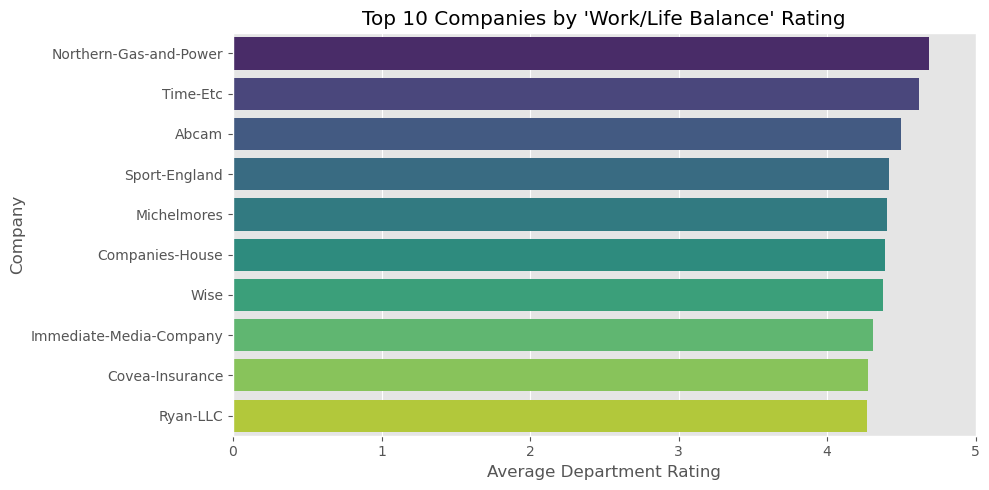

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/4227344795.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='viridis')


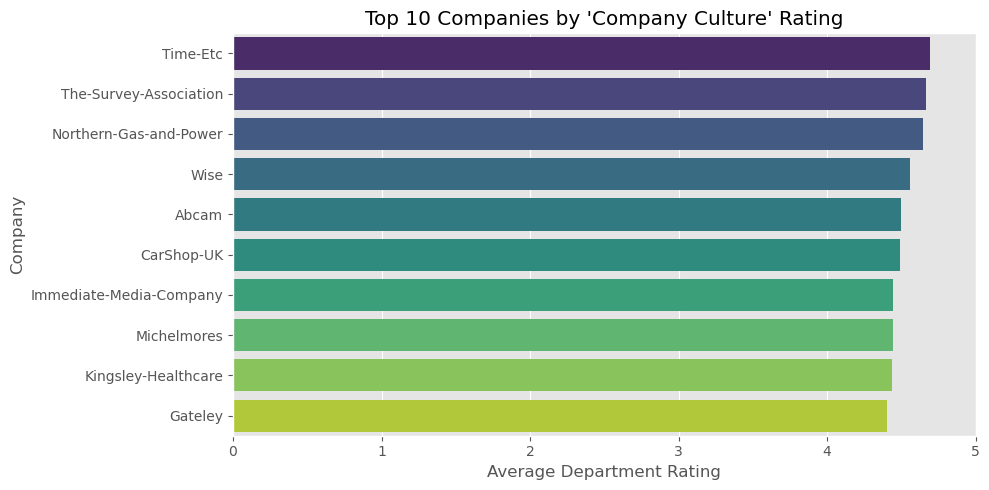

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/4227344795.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='viridis')


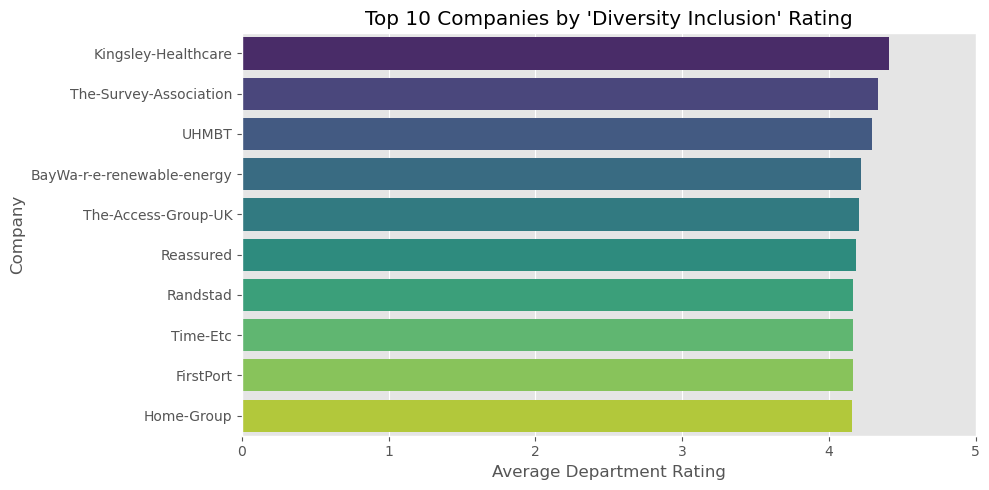

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/4227344795.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='viridis')


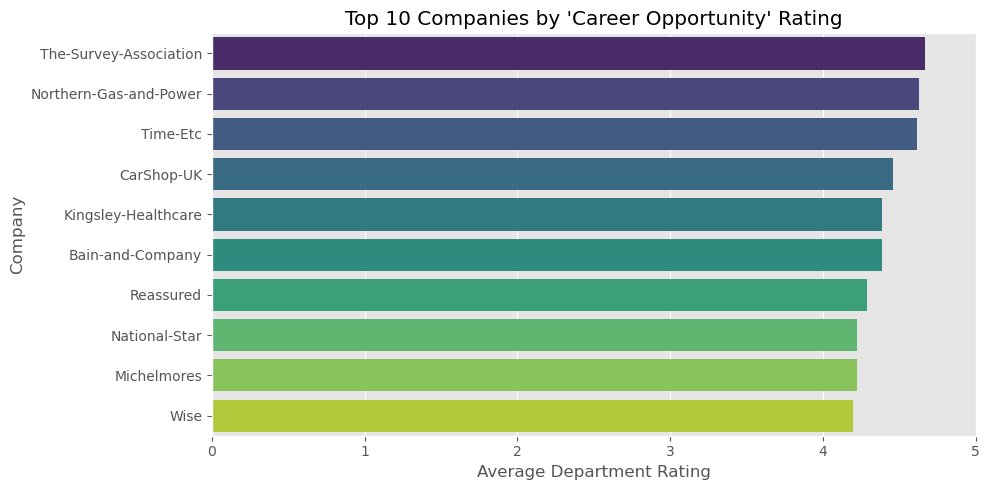

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/4227344795.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='viridis')


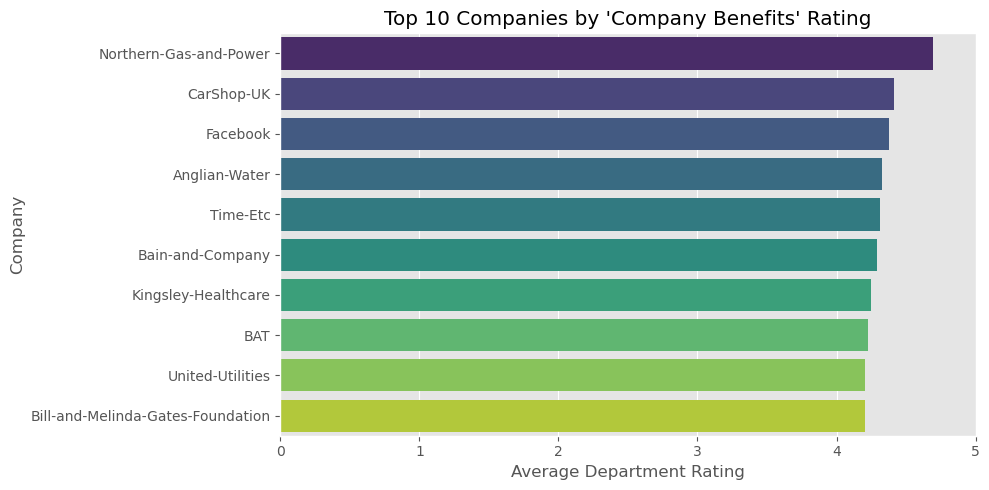

/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/4227344795.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='viridis')


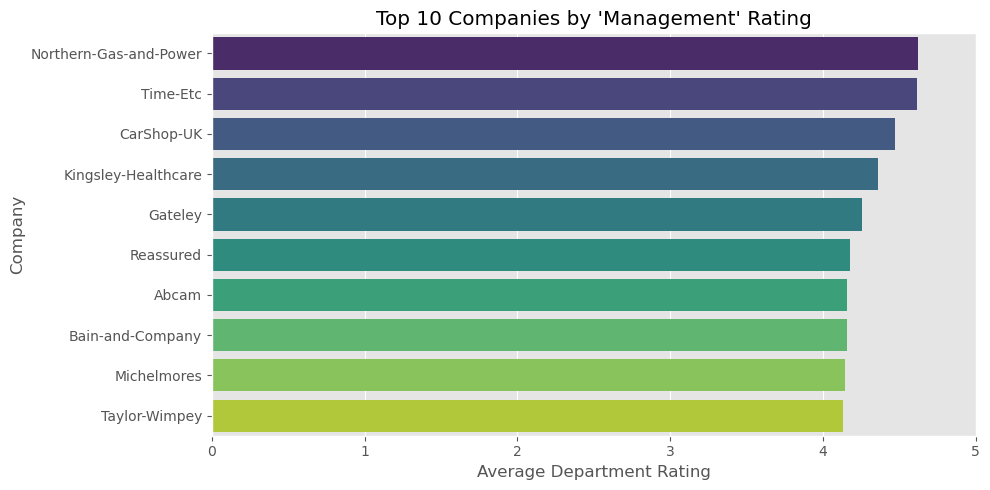

In [ ]:
# Visualize trends by department using top 10 companies for each department rating
# Get top 10 companies for each department

# Plot for each department
for department in department_cols:
    temp_df = textblob_df[['Company', department]].dropna()

    # Get average score by company
    avg_scores = (
        temp_df.groupby('Company')[department]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x=avg_scores.values, y=avg_scores.index, palette='viridis')
    plt.title(f"Top 10 Companies by '{department}' Rating")
    plt.xlabel("Average Department Rating")
    plt.ylabel("Company")
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()


“The following plots identify companies that excel in specific departments. These trends help uncover which areas—such as management or culture—contribute most to a company's overall positive employee sentiment.”

### Correlation of department ratings with sentiment and overall rating

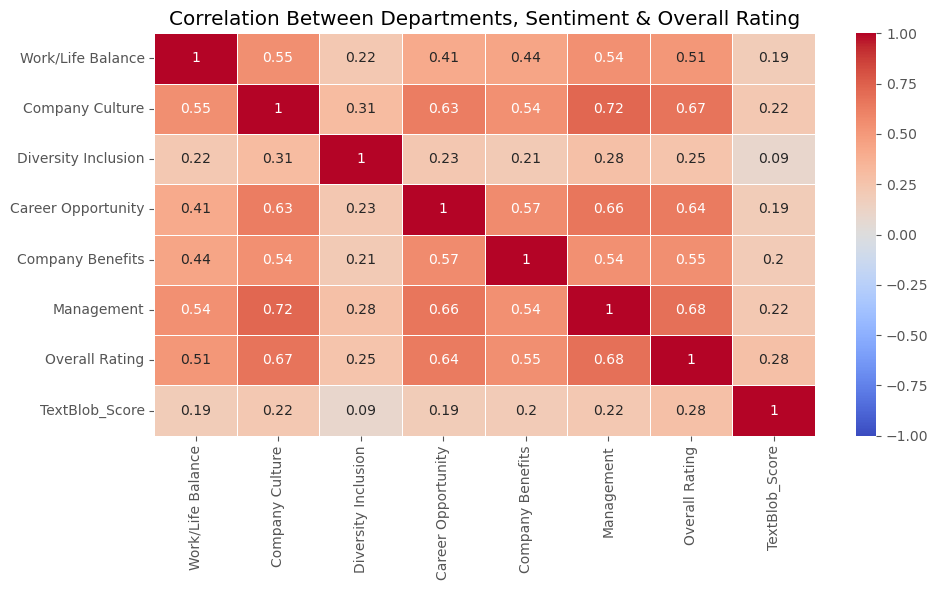

In [ ]:
cols_for_corr = department_cols + ['Overall Rating', 'TextBlob_Score']
corr_df = textblob_df[cols_for_corr].dropna()

# Compute correlation matrix
correlation_matrix = corr_df.corr().round(2)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="white",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Between Departments, Sentiment & Overall Rating")
plt.tight_layout()
plt.show()


Insights You Can Report:
Strongest correlation with Overall Rating:

Management: 0.69
Company Culture: 0.66
Career Opportunity: 0.64


Highest correlation with TextBlob_Score (sentiment):

Overall Rating: 0.31 → Good alignment
Management & Company Culture: 0.24
Other departments: very weakly correlated 

What this tells you:
"Sentiment analysis aligns most with Overall Rating, suggesting that textual content reflects general review positivity. However, departments like Management and Company Culture appear to drive both overall rating and sentiment tone."

### Radar Chart 

pick 3–5 top companies and visualize their strengths across the 6 departments.



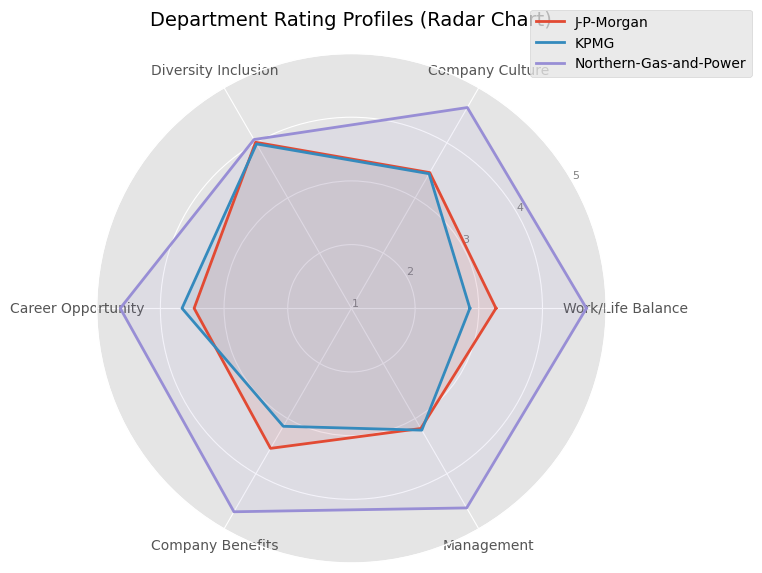

In [ ]:
#  Radar chart for department profiles of top companies

from math import pi

# Choose 3 standout companies from previous dot matrix or heatmap
selected_companies = [
    "Northern-Gas-and-Power",
    "J-P-Morgan",
    "KPMG",
] 

# Average department ratings for selected companies
radar_data = textblob_df[textblob_df['Company'].isin(selected_companies)]

# Compute mean for each department per company
company_profiles = radar_data.groupby('Company')[department_cols].mean().round(2)

labels = department_cols
num_vars = len(labels)

# Convert to angle coordinates
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

# Initialize radar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot each company
for company in company_profiles.index:
    values = company_profiles.loc[company].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=company, linewidth=2)
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], labels, fontsize=10)
ax.set_rlabel_position(30)
plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=8)
plt.ylim(1, 5)
plt.title("Department Rating Profiles (Radar Chart)", size=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


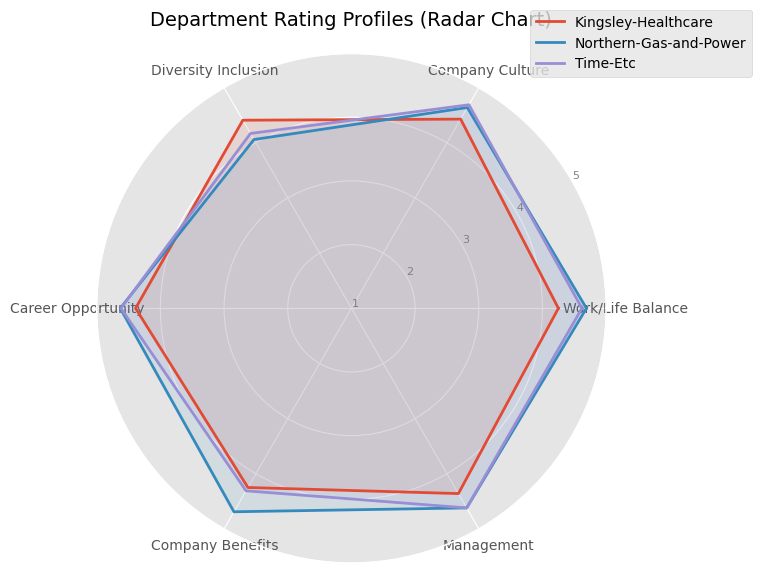

In [ ]:
from math import pi


# Radar Chart for Lowest-Rated Companies
# Choose 3 lowest-rated companies from previous dot matrix or heatmap
selected_companies_low = [
    "The-National-gallery",
    "Time-Etc",
    "Tate-Modern"
]
# Average department ratings for selected companies
radar_data_low = textblob_df[textblob_df['Company'].isin(selected_companies_low)]

# Compute mean for each department per company
company_profiles_low = radar_data_low.groupby('Company')[department_cols].mean().round(2)

labels_low = department_cols
num_vars_low = len(labels_low)

angles_low = [n / float(num_vars_low) * 2 * pi for n in range(num_vars_low)]
angles_low += angles_low[:1]  

plt.figure(figsize=(8, 8))
ax_low = plt.subplot(111, polar=True)

# Plot each company
for company in company_profiles_low.index:
    values_low = company_profiles_low.loc[company].tolist()
    values_low += values_low[:1]  
    ax_low.plot(angles_low, values_low, label=company, linewidth=2)
    ax_low.fill(angles_low, values_low, alpha=0.1)

plt.xticks(angles_low[:-1], labels_low, fontsize=10)
ax_low.set_rlabel_position(30)
plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=8)
plt.ylim(1, 5)
plt.title("Department Rating Profiles (Radar Chart)", size=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


### Mismatches - bias detection?

In [ ]:
# Prepare clean tables for export or display

# Group by company to compute average sentiment and overall rating
company_comparison = textblob_df.groupby('Company')[['TextBlob_Score', 'Overall Rating']].mean()
company_comparison = company_comparison.round(2)

# Normalize both to identify mismatches
norm_sentiment = (company_comparison['TextBlob_Score'] - company_comparison['TextBlob_Score'].min()) / (
    company_comparison['TextBlob_Score'].max() - company_comparison['TextBlob_Score'].min()
)
norm_rating = (company_comparison['Overall Rating'] - company_comparison['Overall Rating'].min()) / (
    company_comparison['Overall Rating'].max() - company_comparison['Overall Rating'].min()
)

# Difference between normalized values
company_comparison['Mismatch'] = (norm_rating - norm_sentiment).round(3)

# Find top mismatches
mismatched_high_sentiment = company_comparison.sort_values(by='Mismatch', ascending=True).head(5)
mismatched_high_rating = company_comparison.sort_values(by='Mismatch', ascending=False).head(5)

# Rename columns for clarity
mismatched_high_sentiment = mismatched_high_sentiment.rename(columns={
    'TextBlob_Score': 'Avg Sentiment Score',
    'Overall Rating': 'Avg Star Rating'
})

mismatched_high_rating = mismatched_high_rating.rename(columns={
    'TextBlob_Score': 'Avg Sentiment Score',
    'Overall Rating': 'Avg Star Rating'
})

# Reset index so "Company" is a column
mismatched_high_sentiment.reset_index(inplace=True)
mismatched_high_rating.reset_index(inplace=True)

# Display formatted tables
print("\nTop 5 Companies with High Sentiment but Low Ratings:\n")
display(mismatched_high_sentiment.style.set_table_attributes("style='display:inline'").background_gradient(
    subset=["Mismatch"], cmap="Blues").format({
    "Avg Sentiment Score": "{:.3f}",
    "Avg Star Rating": "{:.1f}",
    "Mismatch": "{:.3f}"
}))

print("\nTop 5 Companies with High Ratings but Low Sentiment:\n")
display(mismatched_high_rating.style.set_table_attributes("style='display:inline'").background_gradient(
    subset=["Mismatch"], cmap="Oranges").format({
    "Avg Sentiment Score": "{:.3f}",
    "Avg Star Rating": "{:.1f}",
    "Mismatch": "{:.3f}"
}))



Top 5 Companies with High Sentiment but Low Ratings:



,Company,Avg Sentiment Score,Avg Star Rating,Mismatch
0,Creative-Support,0.150,2.3,-0.442
1,Rural-Payments-Agency,0.210,2.6,-0.435
2,Curtis-Banks,0.170,2.4,-0.418
3,Link-Group,0.170,2.5,-0.411
4,Diligenta,0.150,2.4,-0.406



Top 5 Companies with High Ratings but Low Sentiment:



,Company,Avg Sentiment Score,Avg Star Rating,Mismatch
0,The-Survey-Association,-0.100,5.0,1.000
1,Engineering-and-Physical-Sciences-Research-Council,0.140,4.3,0.302
2,National-Star,0.180,4.3,0.242
3,Southern-Health-and-Social-Care-Trust,0.210,4.4,0.204
4,Bain-and-Company,0.260,4.6,0.176


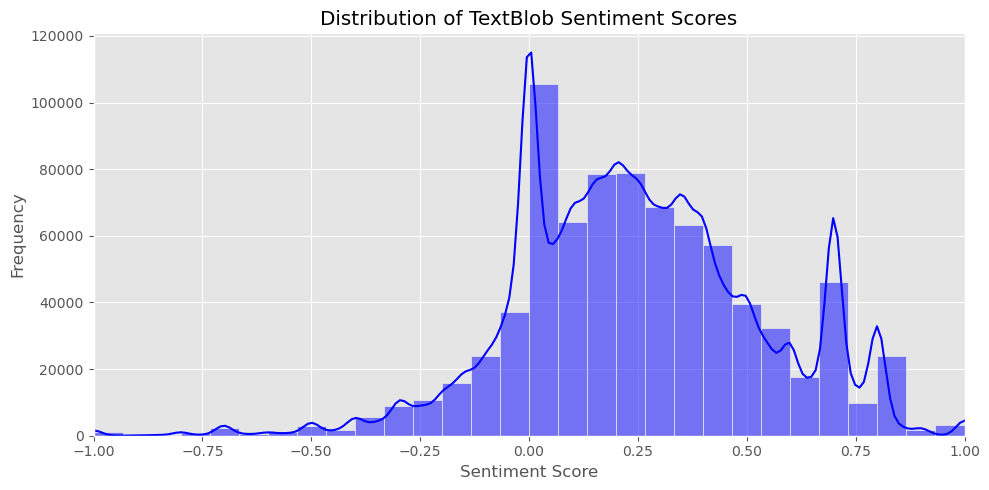

In [ ]:
# distribution of sentiment scores
plt.figure(figsize=(10, 5))
sns.histplot(textblob_df['TextBlob_Score'], bins=30, kde=True, color='blue')
plt.title("Distribution of TextBlob Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

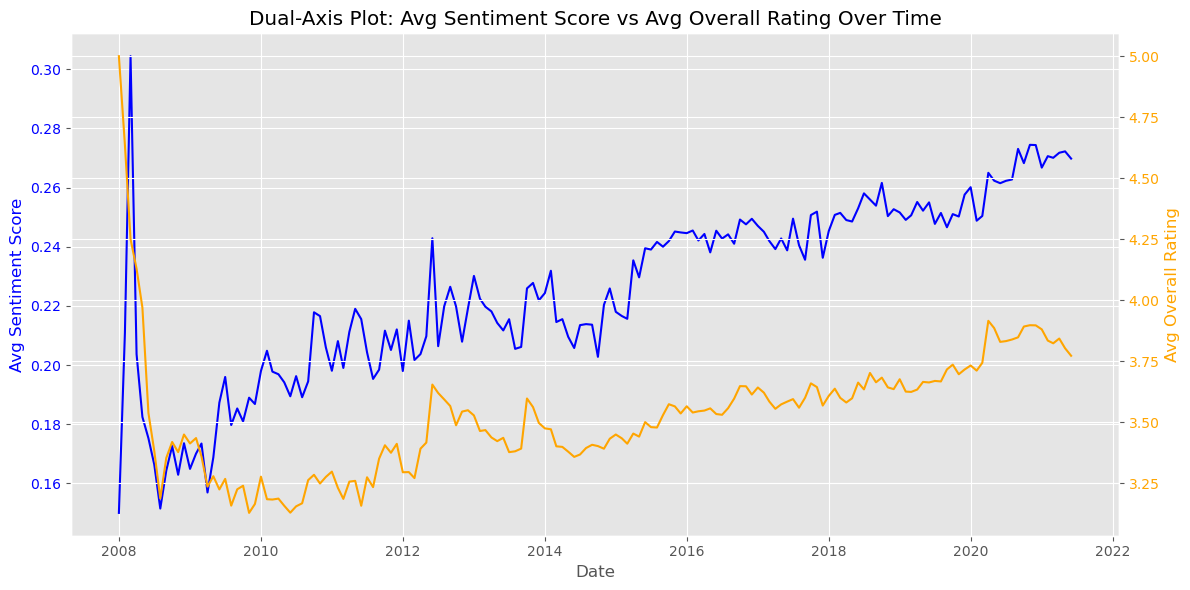

In [ ]:
#Dual-Axis Plot: Sentiment vs Ratings Over Time
# Convert date column to datetime
textblob_df['Date Posted'] = pd.to_datetime(textblob_df['Date Posted'], errors='coerce')
# Drop rows with NaT in Date
textblob_df = textblob_df.dropna(subset=['Date Posted'])
# Extract year and month for grouping
textblob_df['YearMonth'] = textblob_df['Date Posted'].dt.to_period('M')
# Group by YearMonth to get average sentiment and overall rating
monthly_data = textblob_df.groupby('YearMonth').agg({
    'TextBlob_Score': 'mean',
    'Overall Rating': 'mean'
}).reset_index()
# Convert YearMonth back to datetime for plotting
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()
# Plotting
plt.figure(figsize=(12, 6))
# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot sentiment score
ax1.plot(monthly_data['YearMonth'], monthly_data['TextBlob_Score'], color='blue', label='Avg Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# Create second y-axis for overall rating
ax2 = ax1.twinx()
ax2.plot(monthly_data['YearMonth'], monthly_data['Overall Rating'], color='orange', label='Avg Overall Rating')
ax2.set_ylabel('Avg Overall Rating', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Dual-Axis Plot: Avg Sentiment Score vs Avg Overall Rating Over Time')
fig.tight_layout()  
plt.show()



Top 10 Companies with the Highest Overall Ratings:



,Company,Avg Overall Rating
0,The-Survey-Association,5.00
1,Time-Etc,4.79
2,Northern-Gas-and-Power,4.73
3,CarShop-UK,4.65
4,Michelmores,4.61
5,Bain-and-Company,4.56
6,Gateley,4.53
7,Sport-England,4.50
8,Kingsley-Healthcare,4.50
9,Taylor-Wimpey,4.50


/var/folders/4f/pyl6rkks11xblvcm36fgp0gm0000gq/T/ipykernel_80864/812501856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg Overall Rating', y='Company', data=top_10_companies, palette='viridis')


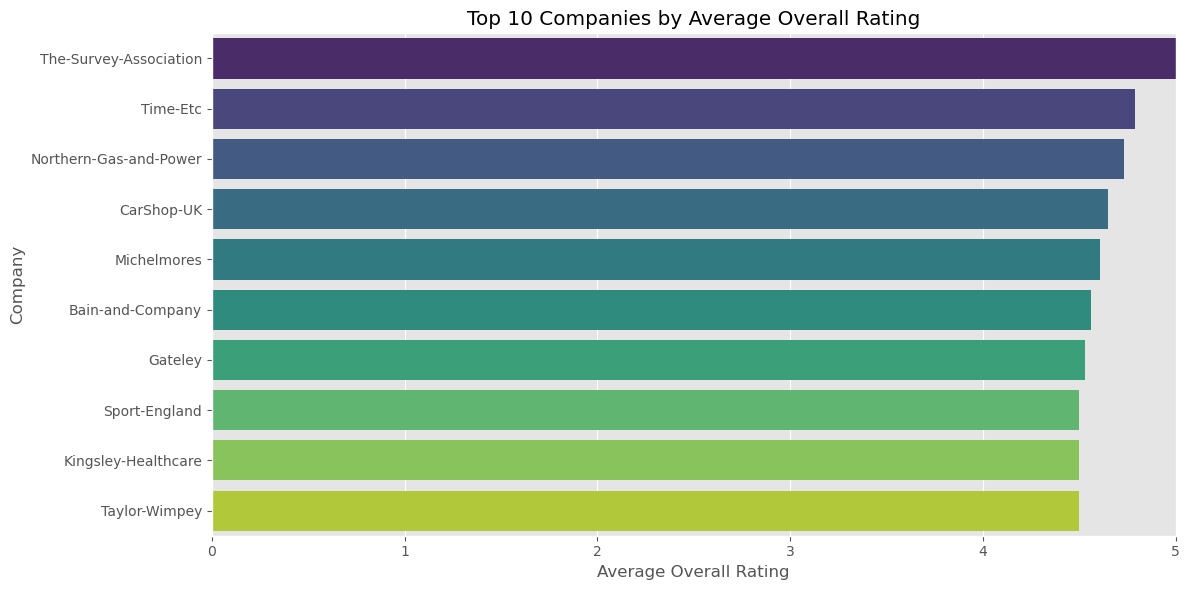

In [ ]:
# top 10 companies with the highest ratings
top_10_companies = textblob_df.groupby('Company')['Overall Rating'].mean().sort_values(ascending=False).head(10)
top_10_companies = top_10_companies.reset_index()
top_10_companies.columns = ['Company', 'Avg Overall Rating']
top_10_companies['Avg Overall Rating'] = top_10_companies['Avg Overall Rating'].round(2)
top_10_companies = top_10_companies.sort_values(by='Avg Overall Rating', ascending=False)
# Display the top 10 companies
print("\nTop 10 Companies with the Highest Overall Ratings:\n")
display(top_10_companies.style.set_table_attributes("style='display:inline'").background_gradient(
    cmap="Greens").format({
    "Avg Overall Rating": "{:.2f}"
}))

# top 10 companies displayed with a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Avg Overall Rating', y='Company', data=top_10_companies, palette='viridis')
plt.title("Top 10 Companies by Average Overall Rating")
plt.xlabel("Average Overall Rating")
plt.ylabel("Company")
plt.xlim(0, 5)
plt.tight_layout()
plt.show()
